<div>
      <img src="https://upload.wikimedia.org/wikipedia/de/5/5b/Hochschule-aalen.svg" width="400px" align="right"/>
</div>



## MLDL Projekt: 
# Implementierung von Deep Learning-Modellen 
##### Vergleich von keras (tensorflow) und pytorch
##### eigene Implementierung von Modellen
##### kritischer Vergleich, Schlussfolgerungen, etc.
## Vorhersage von Flugverspätungen in USA
---
Modul: Machine Learning & Deep Learning\
**Eugen Jeroschkin, Patrick Kurz, Andreas Schulz, Herbi Shtini**\
Submission: 14.10.2022 | SS2022 | Prof. Dr. Andreas Theissler

---

---
## Vorhersage von Flugverspätungen in USA
### Implementierung PyTorch
---

<h2>Inhaltsverzeichnis</h1>
<ol>
  <li>Das Model</li>
  <li>Train & Test Methoden</li>
  <li>Cross-Validation</li>
  <li>Parameter-Tuning</li>
  <li>Model Speichern</li>
</ul>


In [32]:
!pip install ray
!pip install optuna

from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt 

from functools import partial
from sklearn.model_selection import KFold

from ray import tune, air
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.air import session
from ray.air.checkpoint import Checkpoint

import torch.optim as optim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
if 'google.colab' in str(get_ipython()):
  IN_COLAB = True
else:
  IN_COLAB = False

if IN_COLAB:
  # Authenticate and create the PyDrive client.
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  downloaded = drive.CreateFile({'id': '1eyIVS-zsTzQCE-b48ZG2RxoLlqBGAkH_'}) 
  downloaded.GetContentFile('2018-prepared-filtered-sample.csv') 

In [34]:
df = pd.read_csv('2018-prepared-filtered-sample.csv') 
df.describe()

,CRS_DEP_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,FL_DATE_WEEKDAY_1,FL_DATE_WEEKDAY_2,FL_DATE_WEEKDAY_3,FL_DATE_WEEKDAY_4,FL_DATE_WEEKDAY_5,FL_DATE_WEEKDAY_6,...,FL_DATE_MONTH_3,FL_DATE_MONTH_4,FL_DATE_MONTH_5,FL_DATE_MONTH_6,FL_DATE_MONTH_7,FL_DATE_MONTH_8,FL_DATE_MONTH_9,FL_DATE_MONTH_10,FL_DATE_MONTH_11,FL_DATE_MONTH_12
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,...,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,1328.280338,802.422635,141.343901,12.739946,0.150964,0.143095,0.143526,0.148524,0.149910,0.122398,...,0.084120,0.083326,0.085755,0.086549,0.089074,0.088785,0.081445,0.086284,0.081177,0.083450
std,490.949374,599.559660,73.495999,34.732988,0.358014,0.350170,0.350609,0.355619,0.356983,0.327745,...,0.277568,0.276375,0.280002,0.281173,0.284850,0.284433,0.273517,0.280783,0.273108,0.276561
min,1.000000,31.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,913.000000,363.000000,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1320.000000,634.000000,122.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1735.000000,1035.000000,171.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2359.000000,4983.000000,704.000000,300.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Features & Target

In [36]:
df.describe()

,CRS_DEP_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,FL_DATE_WEEKDAY_1,FL_DATE_WEEKDAY_2,FL_DATE_WEEKDAY_3,FL_DATE_WEEKDAY_4,FL_DATE_WEEKDAY_5,FL_DATE_WEEKDAY_6,...,FL_DATE_MONTH_3,FL_DATE_MONTH_4,FL_DATE_MONTH_5,FL_DATE_MONTH_6,FL_DATE_MONTH_7,FL_DATE_MONTH_8,FL_DATE_MONTH_9,FL_DATE_MONTH_10,FL_DATE_MONTH_11,FL_DATE_MONTH_12
count,207113.000000,207113.000000,207113.000000,207113.000000,207113.000000,207113.000000,207113.000000,207113.000000,207113.000000,207113.000000,...,207113.000000,207113.000000,207113.000000,207113.000000,207113.000000,207113.000000,207113.000000,207113.000000,207113.000000,207113.000000
mean,1382.585651,839.169434,145.004794,14.214636,0.152839,0.137809,0.141348,0.157035,0.161395,0.111929,...,0.085205,0.082428,0.085277,0.090347,0.092635,0.088922,0.071739,0.086933,0.088647,0.086146
std,475.430466,593.555676,72.603193,11.445973,0.359833,0.344700,0.348381,0.363835,0.367896,0.315280,...,0.279187,0.275017,0.279294,0.286679,0.289922,0.284632,0.258055,0.281738,0.284235,0.280581
min,303.000000,151.000000,51.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,399.000000,91.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1405.000000,674.000000,125.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1755.000000,1066.000000,174.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2359.000000,4983.000000,681.000000,44.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
monthCols, weekdayCols = [], []
for a in range(12):
  monthCols.append(f"FL_DATE_MONTH_{a + 1}")
for a in range(7):
  weekdayCols.append(f"FL_DATE_WEEKDAY_{a + 1}")

In [38]:
# Features & Target
COLS_FEATURES = [*monthCols, *weekdayCols ,'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE']
COLS_TARGET = ['ARR_DELAY']

Typänderung von int/double zu float32

In [39]:
for item in [*COLS_FEATURES, *COLS_TARGET]:
  df[item] = df[item].astype('float32')

Data normalization

In [40]:
# apply normalization techniques
normalize = False
if normalize:
  for column in df.columns:
    df[column] = df[column] / df[column].abs().max()

#### Data-Loaders

Gruppierung von Features in einem Tensor-Datensatz und die Targets in einem anderen Tensor-Datensatz. Dann wird ein vollständiger Datensatz mit beiden erstellt

In [41]:
torch_tensor_features = torch.tensor(df[COLS_FEATURES].values)
torch_tensor_target = torch.tensor(df[COLS_TARGET].values)

torch_dataset = torch.utils.data.TensorDataset(torch_tensor_features, torch_tensor_target) 

Wir teilen die Daten auf, 80% für das Training und 20% für die Tests

In [42]:
# Train/Split
train_set, test_set = torch.utils.data.random_split(torch_dataset, [ int(len(torch_dataset)*0.8), (len(torch_dataset) - int(len(torch_dataset)*0.8)) ] )

In [43]:
# We pass the "Dataset" as an argument to "DataLoader".
# in the dataloader iterable will return a batch of 64 features and labels.

batch_size = 5000
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [44]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


#### Model

In [45]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, layers = [25, 25]):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        sequentials = []
        for index, l in enumerate(layers): # Generate Sequntial-Layers based on input
          if index == 0:
            sequentials.append(nn.Linear(len(COLS_FEATURES), layers[index]))
            sequentials.append(nn.ReLU())
          if index != 0 & index != len(layers) - 1:
            sequentials.append(nn.Linear(layers[index - 1], layers[index]))
            sequentials.append(nn.ReLU())
          if index == len(layers) - 1:
            sequentials.append(nn.Linear(layers[index - 1], 1))
            #sequentials(torch.nn.Softmax())
        self.linear_relu_stack = nn.Sequential(*sequentials)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

##### Model - Train & Test 

In [46]:
# In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
# backpropagates the prediction error to adjust the model's parameters.
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      # Compute prediction error
      pred = model(X)
      loss = loss_fn(pred, y)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

# We also check the model's performance against the test dataset to ensure it is learning.
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  preds, ys = [], []
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      preds.extend(pred)
      ys.extend(y)

      return preds, ys, test_loss

def accuracy(preds, ys, pct):
  n_correct, n_wrong = 0, 0
  for index, pred in enumerate(preds):
    abs_delta = np.abs(pred - ys[index])
    max_allow = np.abs((1 + pct) * ys[index])
    if abs_delta < max_allow:
      n_correct +=1
    else:
      n_wrong += 1

  return n_correct / (n_correct + n_wrong)

# To train a model, we need a `loss function for regression model
loss_fn = nn.MSELoss()

In [47]:
def trainModel(layers=[100, 100], epochs= 10):
  model = NeuralNetwork(layers=[100, 100]).to(device)
  optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0001)

  losses, accuracies, y, pred = [], [], [], []

  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train(dataloader=train_loader, model=model, loss_fn=loss_fn, optimizer=optimizer)
      testRes = test(test_loader, model, loss_fn)
      losses.append(testRes[2])
      # accuracy
      pred = list(map(lambda a: a.item(), testRes[0]))
      y = list(map(lambda a: a.item(), testRes[1]))
      accuracies.append(accuracy(pred, y, 0.5))

  print(f"Accuracy = {np.array(accuracies).sum()/len(accuracies) * 100}%")

  return model, losses, accuracies, y, pred


model, losses, accuracies, y, pred  = trainModel()

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Accuracy = 73.89%


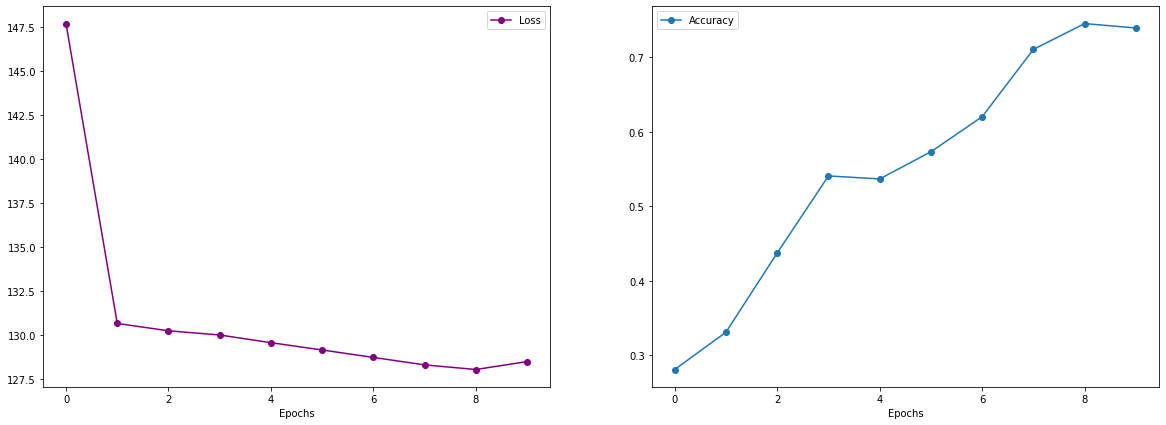

In [51]:
def plotLossAndAccuracy(losses, accuracies):  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
  ax1.plot(losses, '-o', color='purple', label='Loss')
  ax1.set_xlabel("Epochs")
  ax1.legend()

  ax2.plot(accuracies, '-o', label='Accuracy')
  ax2.set_xlabel("Epochs")
  ax2.legend()
  plt.show()

plotLossAndAccuracy(losses, accuracies)

In [ ]:
def showLossPlot(y_test, y_pred):
  fig, ax = plt.subplots(1, 1, figsize=(9, 7) )
  sns.set_theme(style="darkgrid")
  sns.scatterplot(y_test, y_pred, ax=ax)
  ax.set_title('Loss')
  ax.set_xlabel('Verspätung')
  ax.set_ylabel('Vorausgesagte Verspätung')
  z = np.polyfit(y_test, y_pred, 1)
  p = np.poly1d(z)
  ax.plot(y_test, p(y_test), color='red')

#showLossPlot(y, pred)

#### Cross-Validation

In [ ]:
def reset_weights(m):
  # resetting model weights to avoid weight leakage.
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

# Define the K-fold Cross Validator
k_folds = 5
num_epochs = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

# For fold results
results = {}

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(torch_dataset)):
  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')

  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(torch_dataset, batch_size=1, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(torch_dataset, batch_size=1, sampler=test_subsampler)
  
  # model
  network = NeuralNetwork(layers=[100, 100])
  network.apply(reset_weights)

  # Initialize optimizer
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
    
  # Run the training loop for defined number of epochs
  for epoch in range(0, num_epochs):
    print(f'Starting epoch {epoch+1}')

    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      # Get inputs
      inputs, targets = data
        
      # Zero the gradients
      optimizer.zero_grad()
        
      # Perform forward pass
      outputs = network(inputs)

      # Compute loss
      loss = loss_fn(outputs, targets)
        
      # Perform backward pass
      loss.backward()
        
      optimizer.step()

  print('Starting testing')

  # Evaluationfor this fold
  correct, total = 0, 0
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for i, data in enumerate(testloader, 0):
      inputs, targets = data

      outputs = network(inputs)

      # Set total and correct
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      #targetList = torch.tensor(list(map(lambda a: a[0].item(), targets)))
      if i == 0:
        print('TEST', outputs.data, predicted, targets)

      correct += np.isclose(outputs.data, targets, atol=10).sum().item() if len(outputs.data) == len(targets) else 0
    
    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (correct / total)

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  sum += value
print(f'Average: {sum/len(results.items())} %')

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Linear(in_features=22, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting testing
TEST tensor([[18.1037]]) tensor([0]) tensor([[6.]])
Accuracy for fold 0: 62 %
--------------------------------
FOLD 1
--------------------------------
Reset trainable parameters of layer = Linear(in_features=22, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting testing
TEST tensor([[15.4130]]) tensor(

#### Parameter-Tuning

In [ ]:
def load_data():
    return train_set, test_set

Model

In [ ]:
best_trial = None
# Define model
class Net(nn.Module):
    def __init__(self, l1=25, l2=25):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        sequentials = []
        sequentials.append(nn.Linear(len(COLS_FEATURES), l1))
        sequentials.append(nn.ReLU())

        sequentials.append(nn.Linear(l1, l2))
        sequentials.append(nn.ReLU())

        sequentials.append(nn.Linear(l2, 1))
        self.linear_relu_stack = nn.Sequential(*sequentials)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Train

In [ ]:
def train_hyper(config, checkpoint_dir=None, data_dir=None, iterations=1):
    net = Net(config["l1"], config["l2"])

    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data()

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(iterations):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000-th mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

Test

In [ ]:
# TEST FUNCTION
def test_hyper_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

Konfiguration & Start-Funktion

In [ ]:
# MAIN START FUNCTION
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2, iterations=10):
   
    data_dir = os.path.abspath("./data")
    load_data()
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    
    reporter = CLIReporter(
        parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    
    result = tune.run(
        partial(train_hyper, data_dir=data_dir, iterations=iterations), 
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial}, 
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    #print("Best trial final validation accuracy: {}".format(
    #    best_trial.last_result["accuracy"]))


main(num_samples=1, max_num_epochs=1, gpus_per_trial=0, iterations=1) # max_num_epochs=10

2022-10-23 19:24:57,755	WARNING callback.py:109 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2022-10-23 19:24:58,519	WARNING worker.py:1829 -- Warning: The actor ImplicitFunc is very large (19 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-10-23 19:24:58,932	WARNING util.py:244 -- The `start_trial` operation took 0.764 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-10-23 19:24:58 (running for 00:00:01.18)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.37 GiB heap, 0.0/3.69 GiB objects
Result logdir: /root/ray_results/train_hyper_2022-10-23_19-24-57
Number of trials: 1/1 (1 RUNNING)
+-------------------------+----------+-----------------+------+------+-----------+--------------+
| Trial name              | status   | loc             |   l1 |   l2 |        lr |   batch_size |
|-------------------------+----------+-----------------+------+------+-----------+--------------|
| train_hyper_616a2_00000 | RUNNING  | 172.28.0.2:1573 |   16 |  256 | 0.0212979 |           16 |
+-------------------------+----------+-----------------+------+------+-----------+--------------+




(func pid=1573) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=1573)   cpuset_checked))


== Status ==
Current time: 2022-10-23 19:25:07 (running for 00:00:09.71)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.37 GiB heap, 0.0/3.69 GiB objects
Result logdir: /root/ray_results/train_hyper_2022-10-23_19-24-57
Number of trials: 1/1 (1 RUNNING)
+-------------------------+----------+-----------------+------+------+-----------+--------------+
| Trial name              | status   | loc             |   l1 |   l2 |        lr |   batch_size |
|-------------------------+----------+-----------------+------+------+-----------+--------------|
| train_hyper_616a2_00000 | RUNNING  | 172.28.0.2:1573 |   16 |  256 | 0.0212979 |           16 |
+-------------------------+----------+-----------------+------+------+-----------+--------------+


(func pid=1573) [1,  2000] loss: nan
== Status ==
Current time: 2022-10-23 19:25:12 (running for 00:00:14.73)
Memory usage on this node: 2.3/12.7 GiB
U

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
2022-10-23 19:25:30,889	INFO tune.py:759 -- Total run time: 33.59 seconds (33.00 seconds for the tuning loop).


Result for train_hyper_616a2_00000:
  accuracy: 0.0
  date: 2022-10-23_19-25-30
  done: true
  experiment_id: c04aa116cf0745e6b30959c95a02607a
  hostname: bbe44acddf64
  iterations_since_restore: 1
  loss: .nan
  node_ip: 172.28.0.2
  pid: 1573
  should_checkpoint: true
  time_since_restore: 28.280117988586426
  time_this_iter_s: 28.280117988586426
  time_total_s: 28.280117988586426
  timestamp: 1666553130
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 616a2_00000
  warmup_time: 0.0038690567016601562
  
== Status ==
Current time: 2022-10-23 19:25:30 (running for 00:00:33.02)
Memory usage on this node: 2.2/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 1.000: nan
Resources requested: 0/2 CPUs, 0/0 GPUs, 0.0/7.37 GiB heap, 0.0/3.69 GiB objects
Result logdir: /root/ray_results/train_hyper_2022-10-23_19-24-57
Number of trials: 1/1 (1 TERMINATED)
+-------------------------+------------+-----------------+------+------+-----------+--------------+--------+--------

In [ ]:
model, losses, accuracies, y, pred = trainModel(layers=[16, 254])
plotLossAndAccuracy(losses, accuracies)

#### Model-Speichern

In [ ]:
torch.save(model.state_dict(), "model.pth")